# MP Plus data train

加入物理特征进行训练
**物理特征包括：**
nsites、crystal_system、space_group、volume、density、
density_atomic、efermi、energy_per_atom、formation_energy_per_atom、is_gap_direct、is_oxide


In [1]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'XGBoost'

In [2]:
current_path = os.getcwd()
current_path

'/workspaces/Bg_pre2'

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [4]:
from sklearn.base import clone
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Load Data

In [5]:
# Load data
file_dir = os.path.join(current_path, './Data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'mp_plus_train_set.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mp_plus_test_set.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']

dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']


In [6]:
dft_train.shape, dft_test.shape

((8268, 145), (2074, 145))

## Model Train

### DFT Model

In [7]:
fig_path = os.path.join(current_path, 'figures', 'MP_plus')
os.makedirs(fig_path, exist_ok=True)

####################################################################################################
[DFT - XGBoost] Training XGBoost on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s


[Pipeline] ............. (step 2 of 2) Processing model, total=   6.0s
Model training completed!
[Train_error] Evaluating DFT XGBoost on DFT train set:
Figure saved to: /workspaces/Bg_pre2/figures/MP_plus/train_error.png


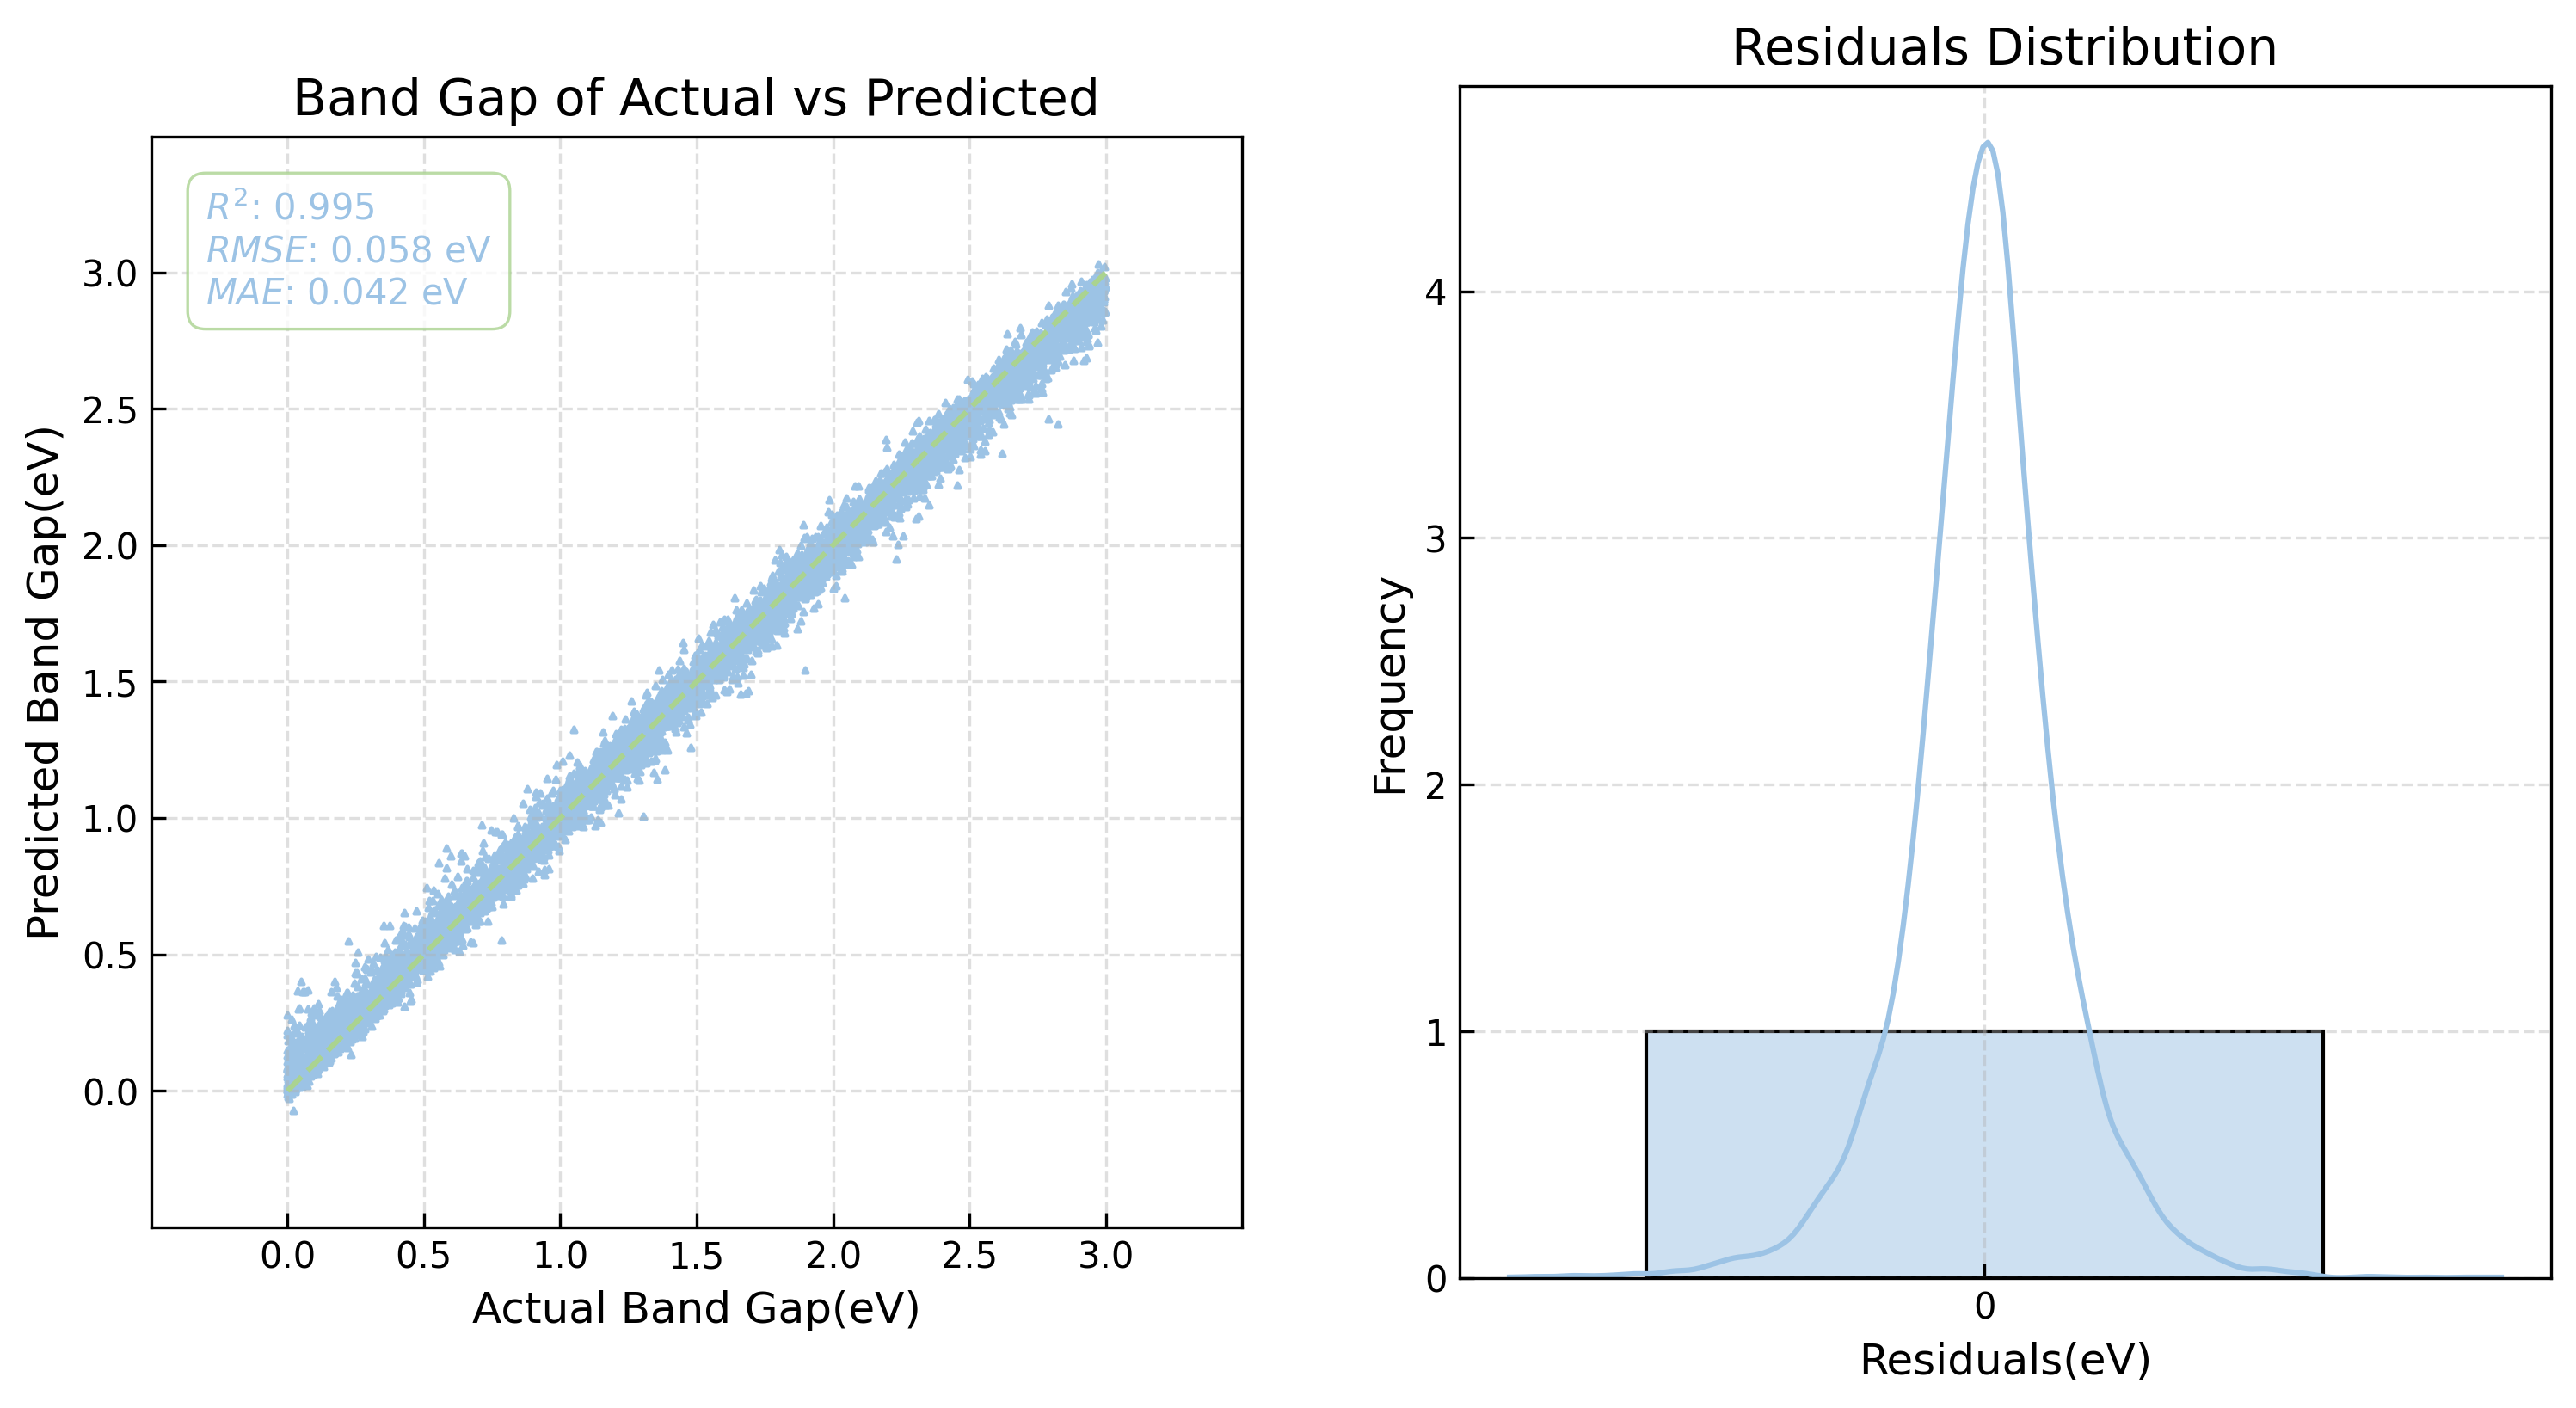


Model Evaluation Results:
Test set size: 8268
Test set: R²: 0.9954 RMSE: 0.0581 MAE: 0.0417 MAPE: 161.5629%
[Test DFT -> DFT] Evaluating DFT XGBoost on DFT test set:
Figure saved to: /workspaces/Bg_pre2/figures/MP_plus/test_error.png


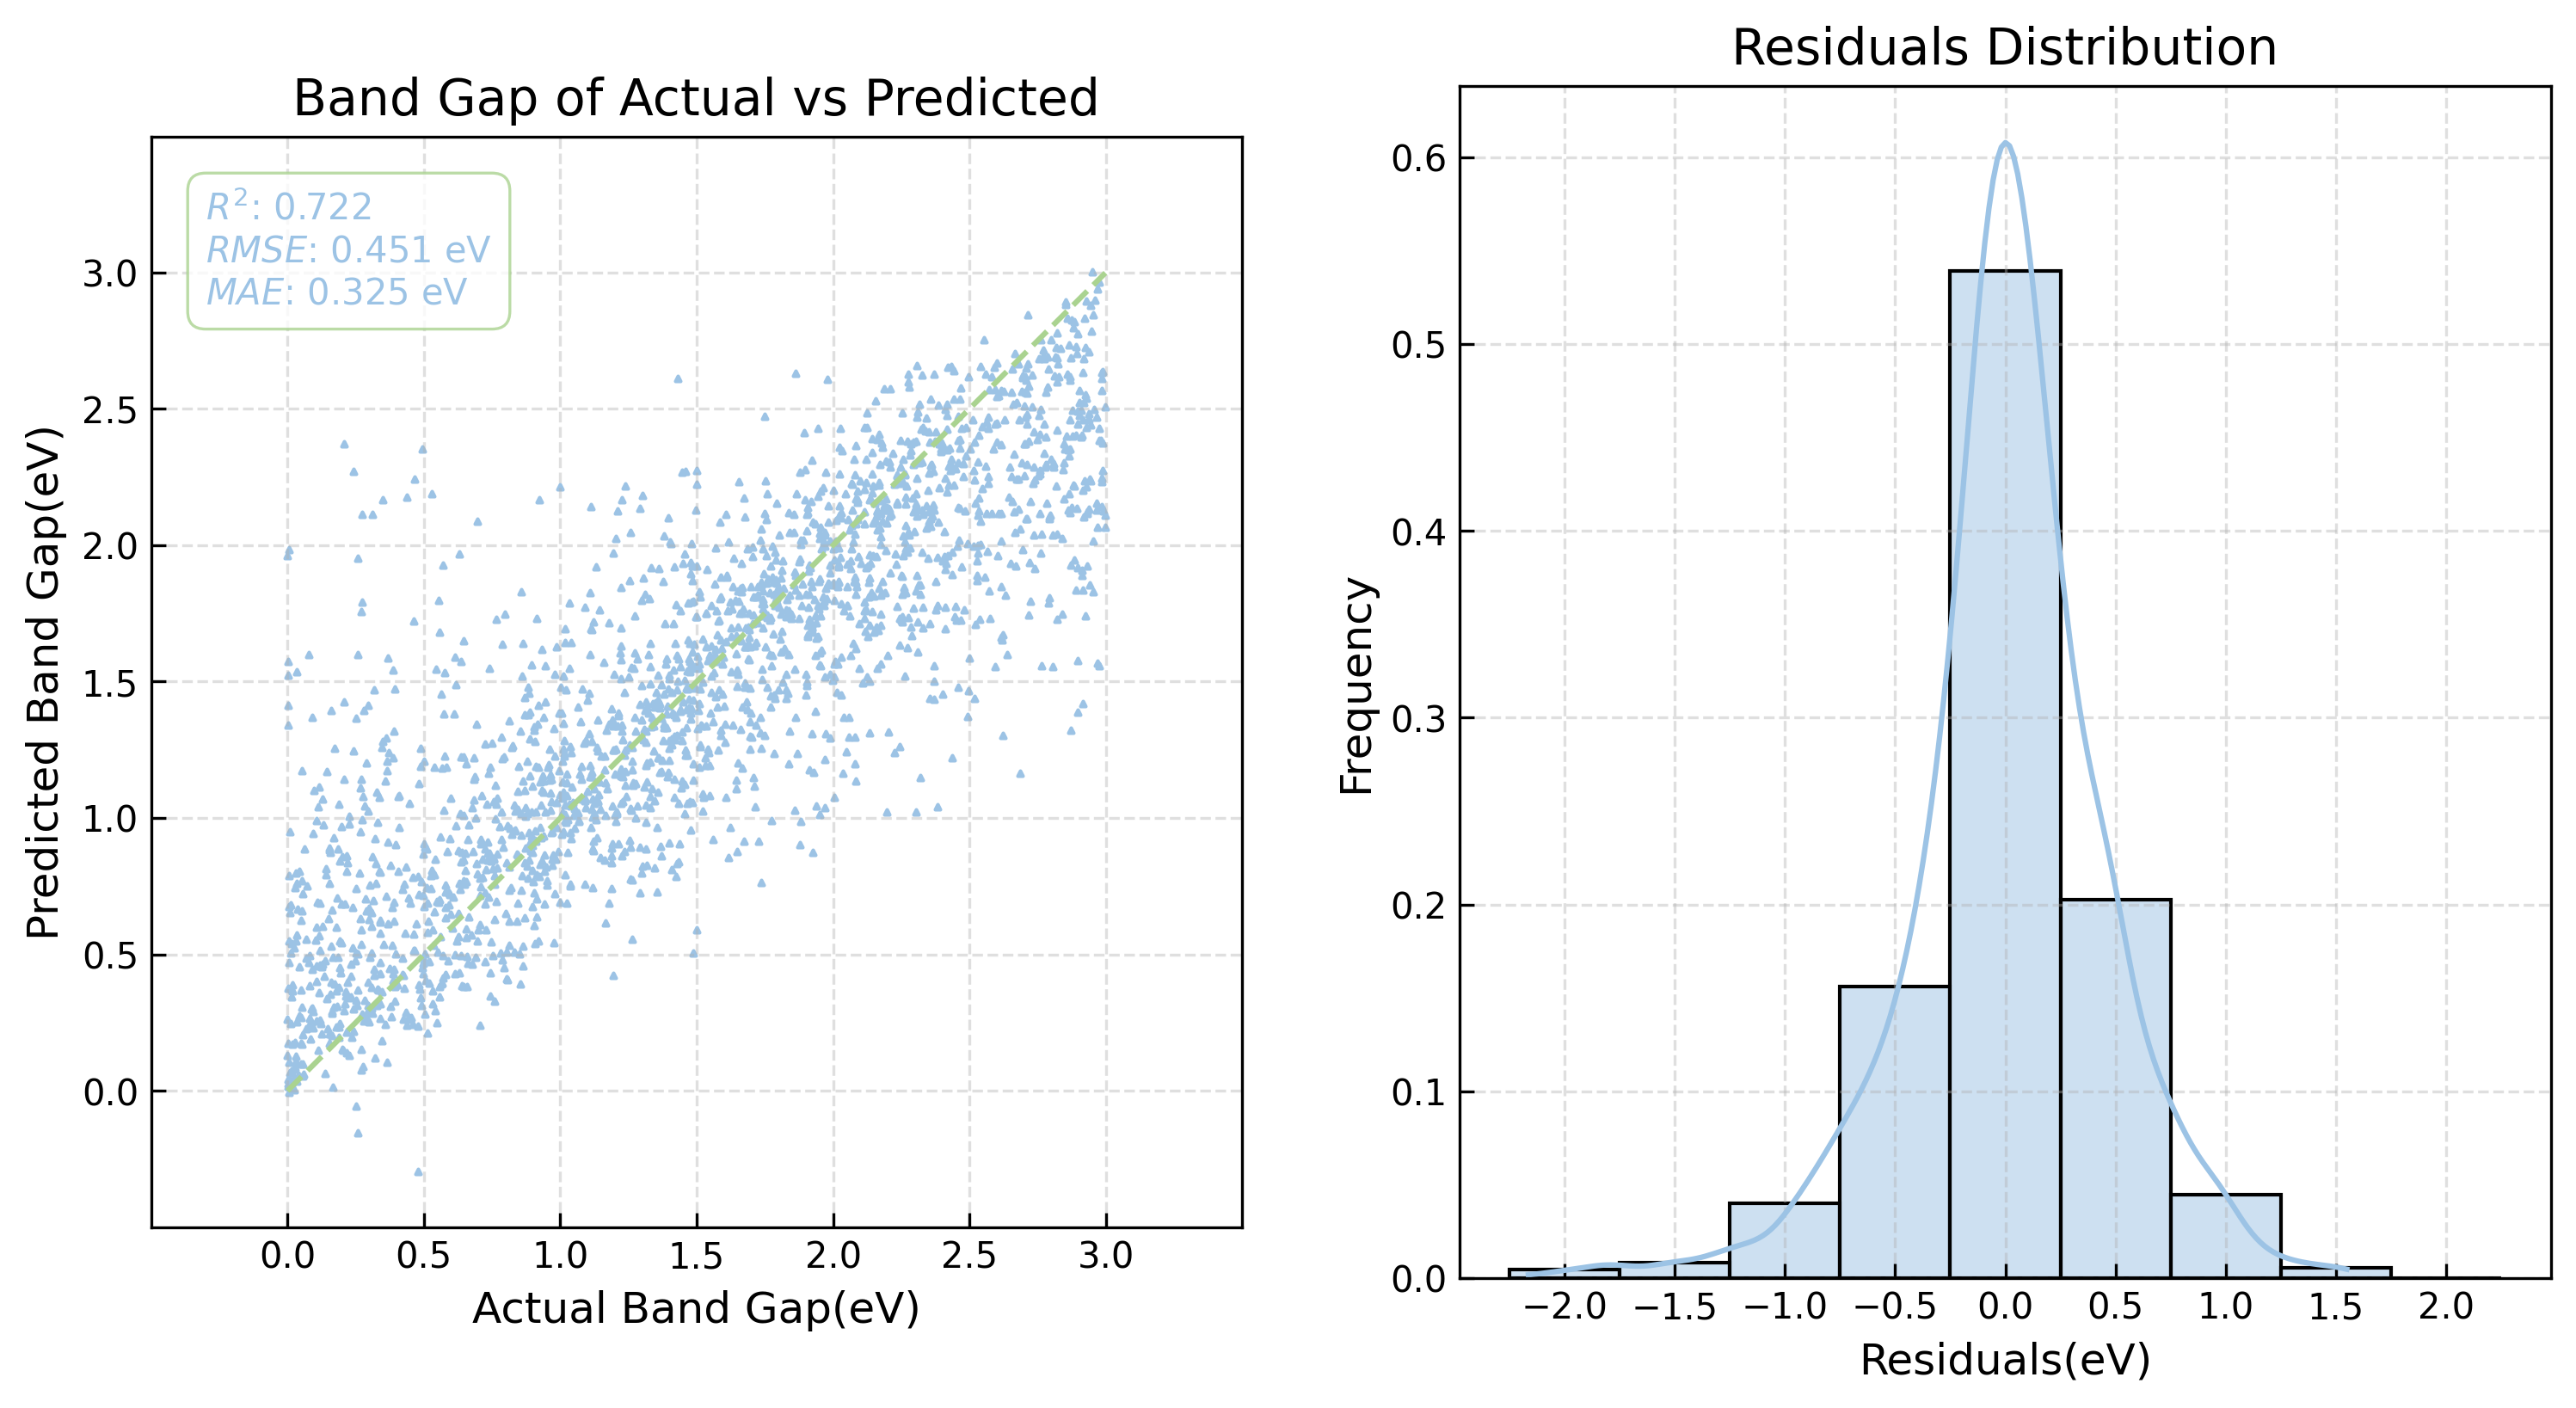


Model Evaluation Results:
Test set size: 2074
Test set: R²: 0.7216 RMSE: 0.4513 MAE: 0.3246 MAPE: 836.9103%


In [8]:
xgboost_best = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
    colsample_bytree=0.7, subsample=1.0, reg_lambda=1.0, alpha=0.5, 
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(xgboost_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y, fig_path=os.path.join(fig_path, 'train_error.png'))
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {MODEL_NAME} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y, fig_path=os.path.join(fig_path, 'test_error.png'))
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

Figure saved to: /workspaces/Bg_pre2/figures/MP_plus/feature_importance.png


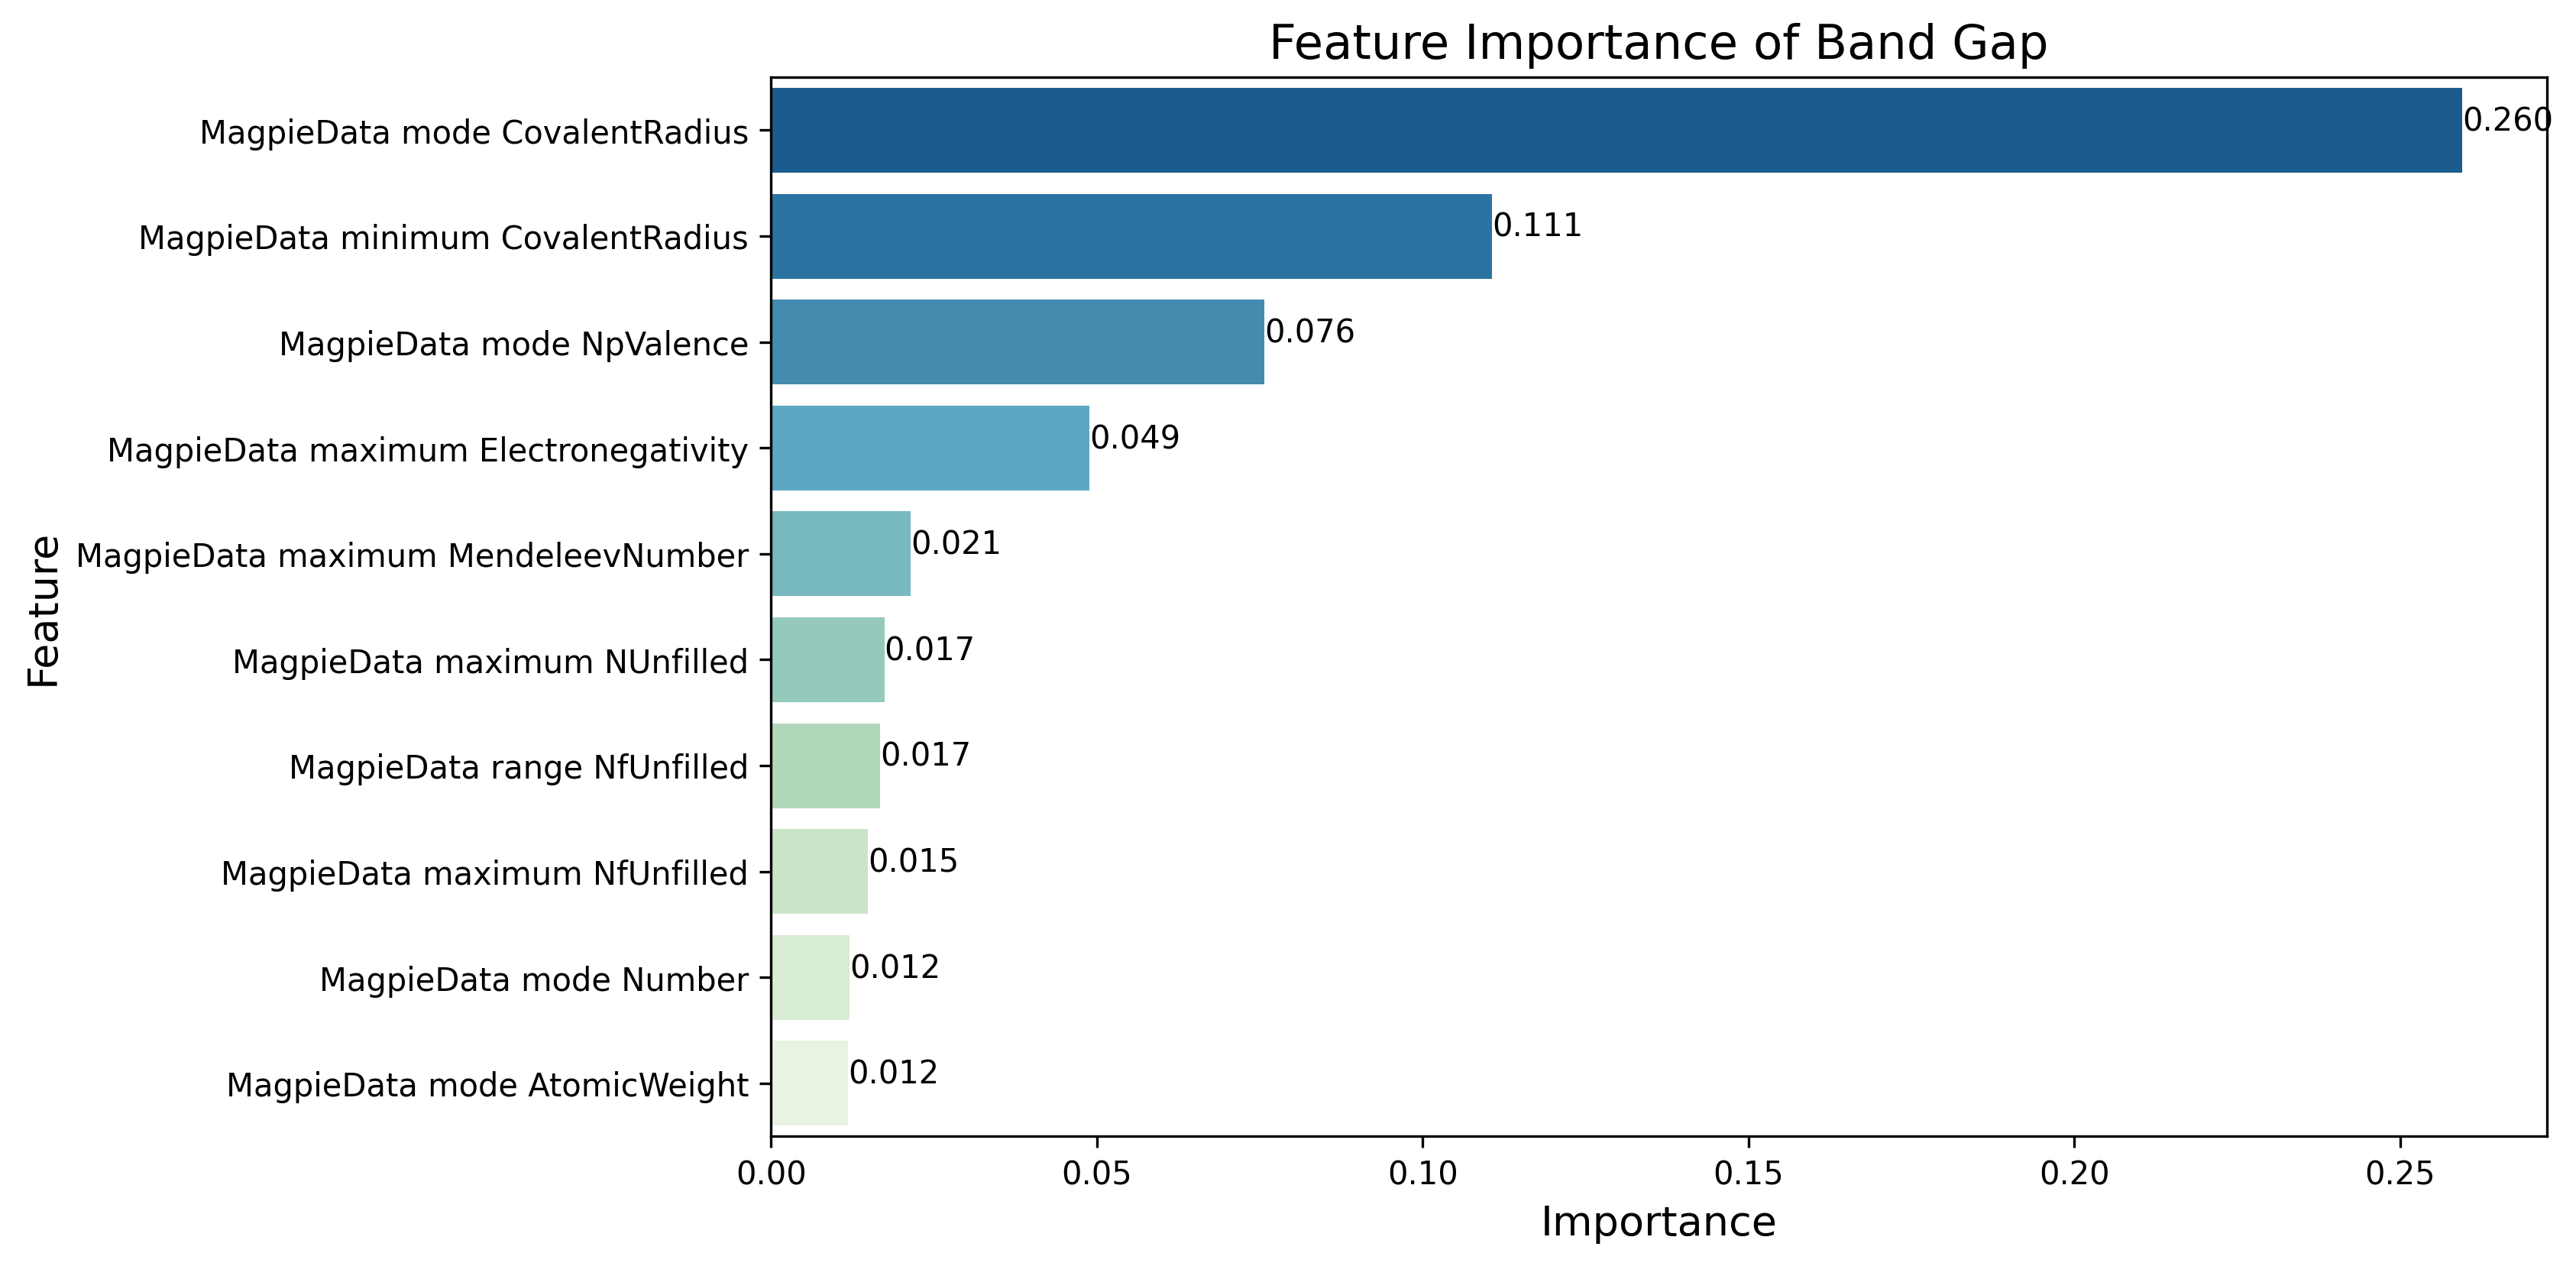

In [9]:
# 绘制特征重要性图
from Utools.draw import plot_feature_importance
importances_df = plot_feature_importance(dft_model.get_model(), dft_train_X.columns, top_n=10,
                            fig_path=os.path.join(fig_path, f'feature_importance.png'))  

In [10]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,XGBoost,Train,dft,dft,0.995449,0.058108,0.041661
1,XGBoost,Test,dft,dft,0.721599,0.451290,0.324574


In [11]:
# Save the model metrics to a CSV file
model_metrics.to_csv(os.path.join('./metrics', 'mp_plus_metrics.csv'), index=False)

## 误差分析

In [12]:
y_pred = dft_model.predict(dft_test_X)
y_pred

array([0.8734788, 1.1752369, 0.8605047, ..., 2.412192 , 0.784872 ,
       2.0985951], shape=(2074,), dtype=float32)

In [13]:
dft_test['y_pred'] = y_pred
dft_test.head()

,composition,nsites,crystal_system,space_group,volume,density,density_atomic,efermi,energy_per_atom,formation_energy_per_atom,...,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,y_pred
0,Ac1H3,4,0,225,49.065716,7.784734,12.266429,6.594725,-20.422506,-0.671802,...,0.0,0.0,0.0,194.0,225.0,31.0,201.750000,11.625000,194.0,0.873479
1,Ac2N2,4,2,186,99.880235,8.013618,24.970059,5.276132,-40.205678,-1.322563,...,0.0,0.0,0.0,194.0,225.0,31.0,209.500000,15.500000,194.0,1.175237
2,Ag4Ge2Pb2S8,16,3,40,364.725495,5.680462,22.795343,3.729416,-4.371751,-0.549878,...,0.0,0.0,0.0,70.0,225.0,155.0,147.500000,77.500000,70.0,0.860505
3,Ag4Hg2S2I4,12,3,36,397.001425,5.874191,33.083452,1.311221,-2.638433,-0.441444,...,0.0,0.0,0.0,64.0,225.0,161.0,135.666667,69.666667,64.0,1.170087
4,Ag4P4Pd2O14,24,4,15,346.044808,4.761193,14.418534,1.535796,-6.480136,-1.785767,...,0.0,0.0,0.0,2.0,225.0,223.0,63.583333,80.708333,12.0,1.011258


In [14]:
dft_test['error'] = np.abs(dft_test['y_pred'] - dft_test['band_gap'])
dft_test['error'].describe()

count    2074.000000
mean        0.324574
std         0.313627
min         0.000260
25%         0.095508
50%         0.224092
75%         0.463300
max         2.164633
Name: error, dtype: float64

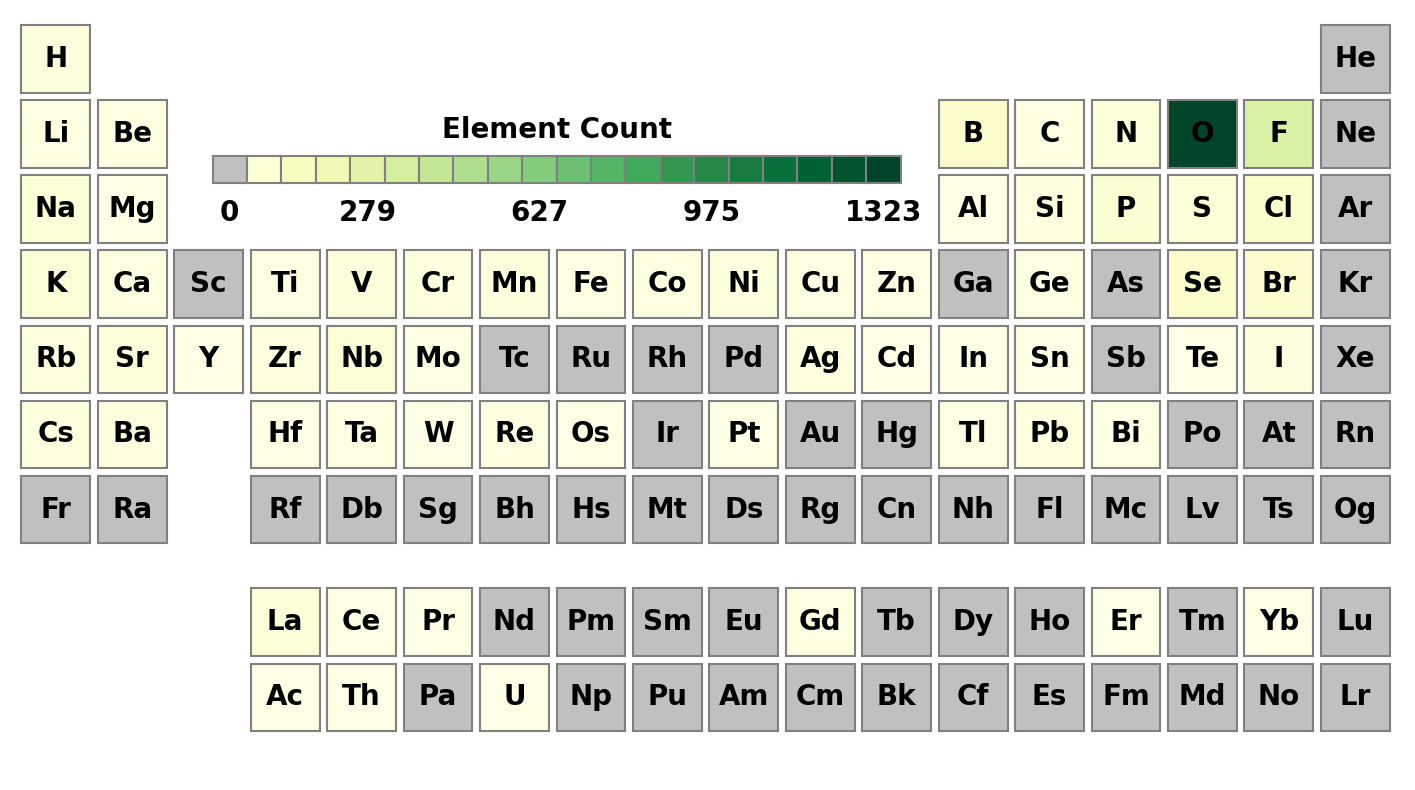

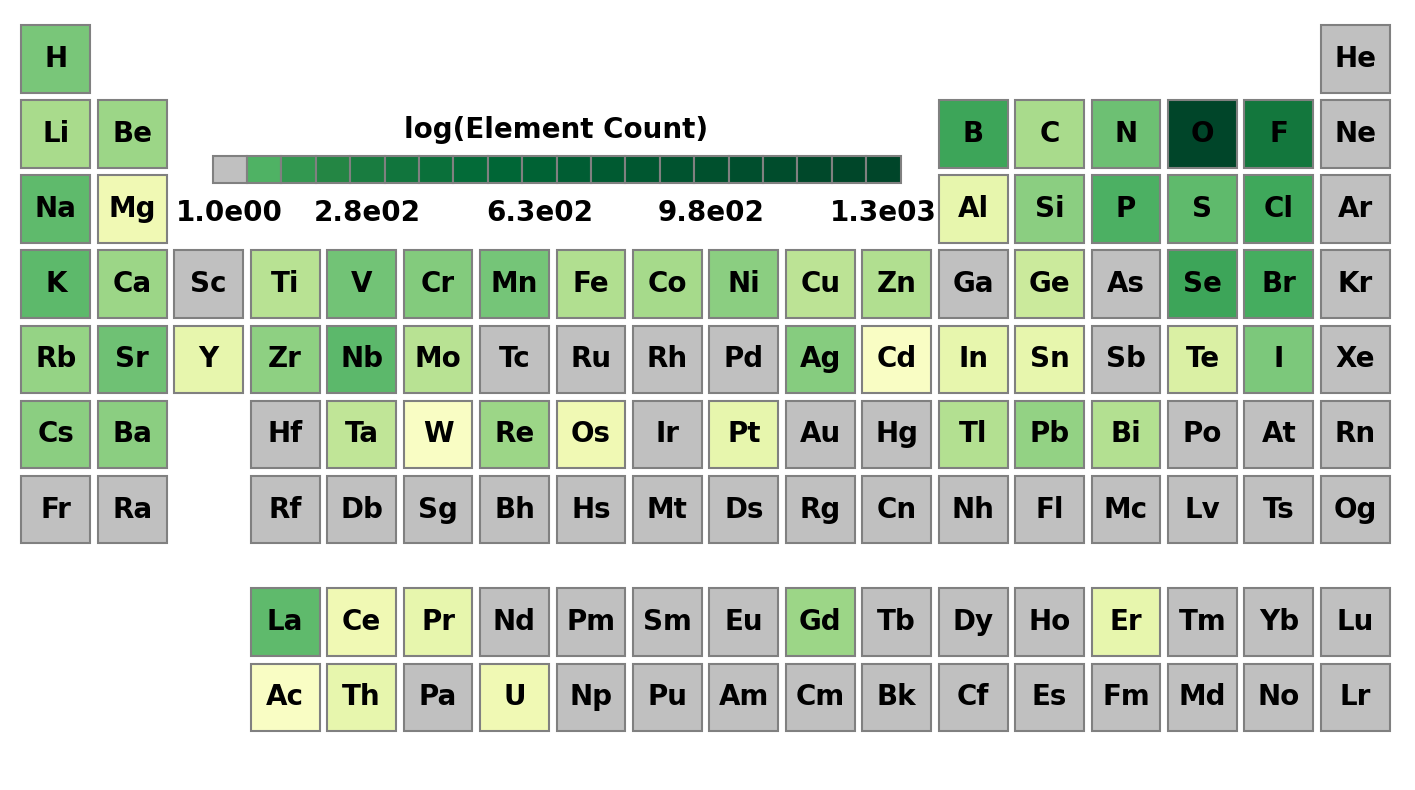

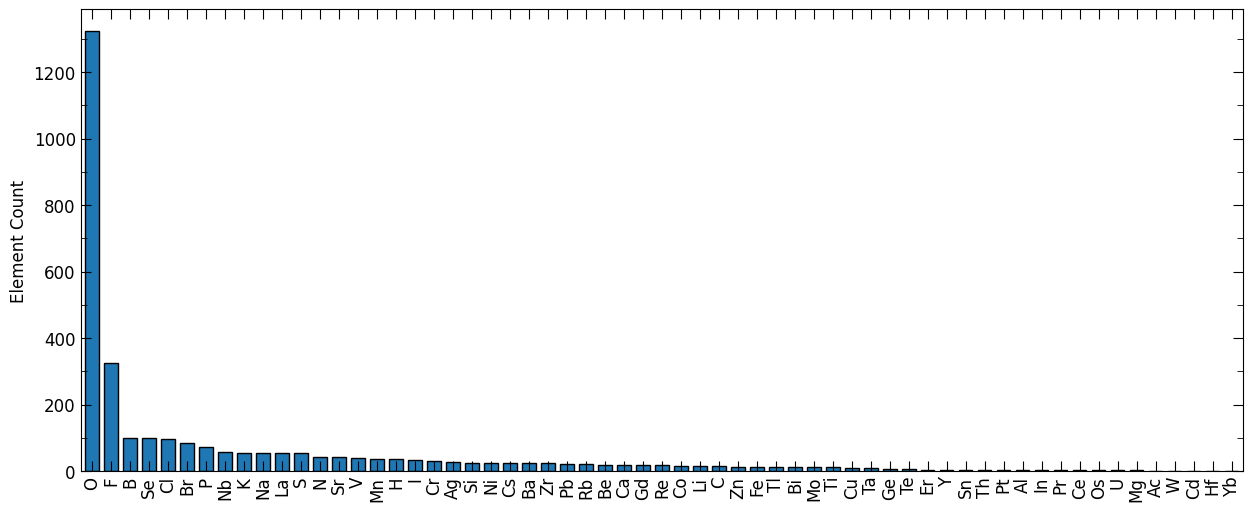

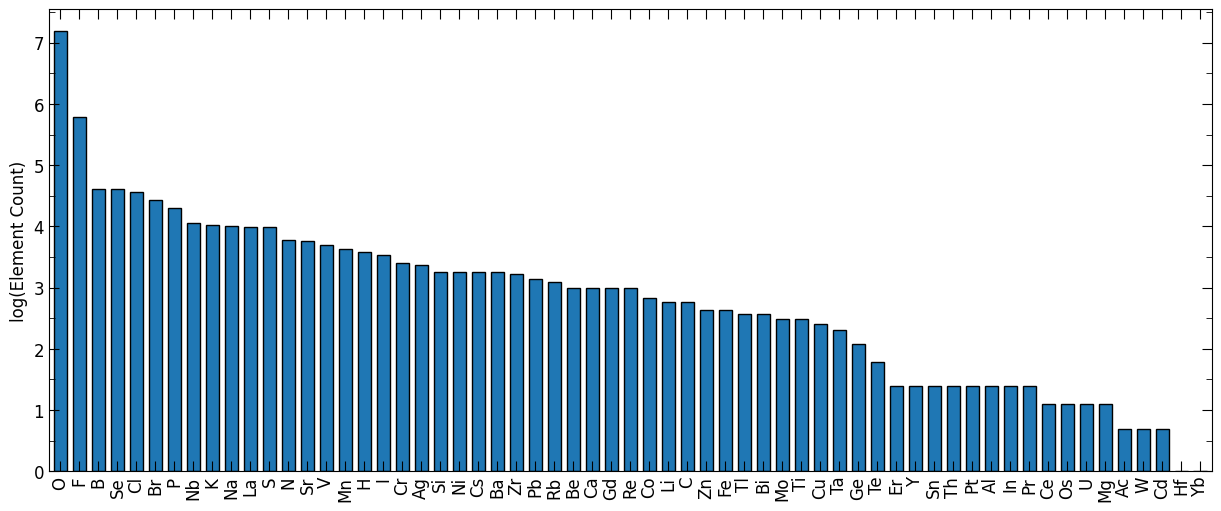

In [15]:
# 误差大于1eV的元素分布
from Utools.ML_figures.figures import element_prevalence
import matplotlib.pyplot as plt

data_df = dft_test[dft_test['error'] > 1.0].copy()
current_dir = os.getcwd()
os.chdir('./Utools')  # Change to where ML_figures is a direct subdirectory

formula = data_df['composition']
save_dir = os.path.join(fig_path, 'error_greater_than_1eV_elements_distribution')
os.makedirs(save_dir, exist_ok=True)
element_prevalence(formula,
                   name='element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=True)

plt.rcParams.update({'font.size': 12})
element_prevalence(formula,
                   name='element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=True)

os.chdir(current_dir)  # Return to previous directory

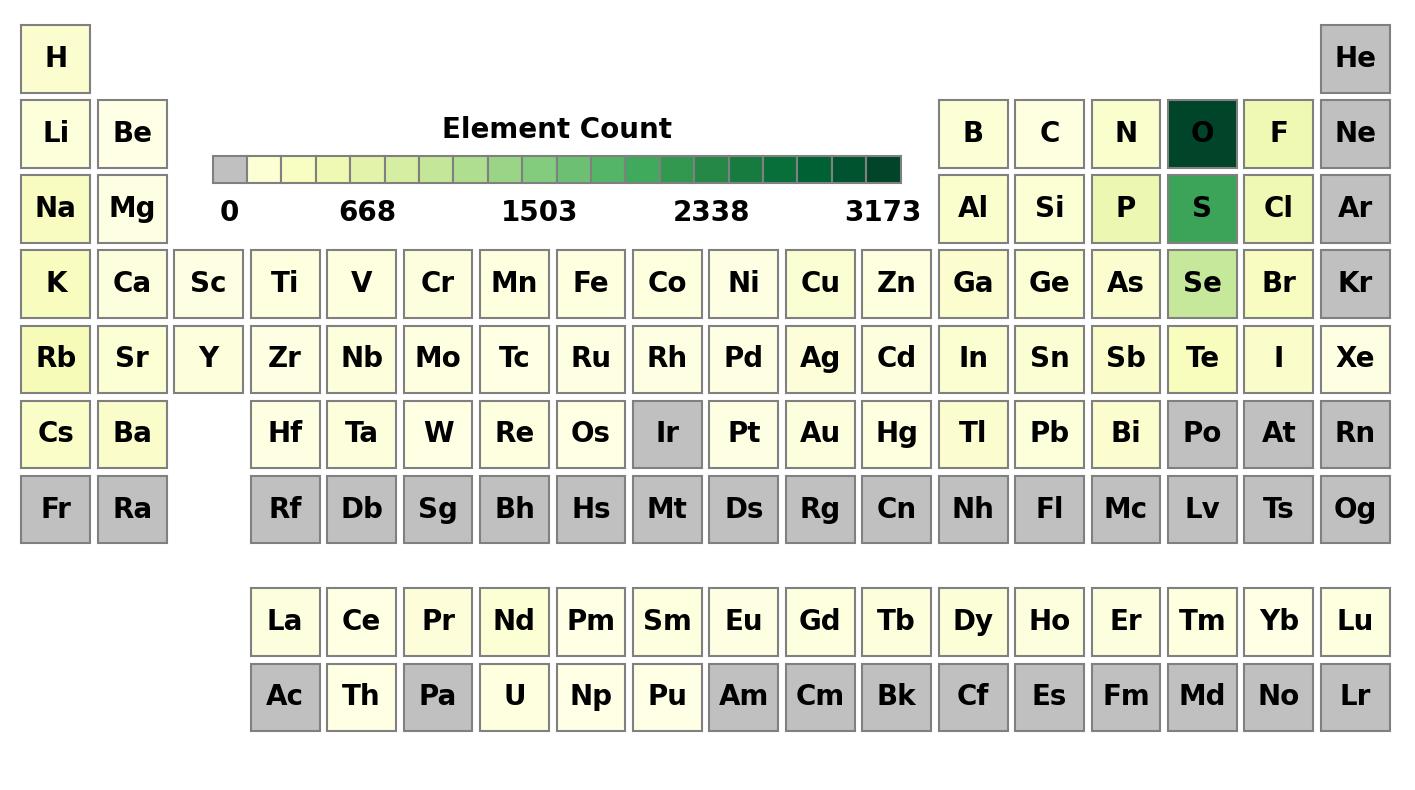

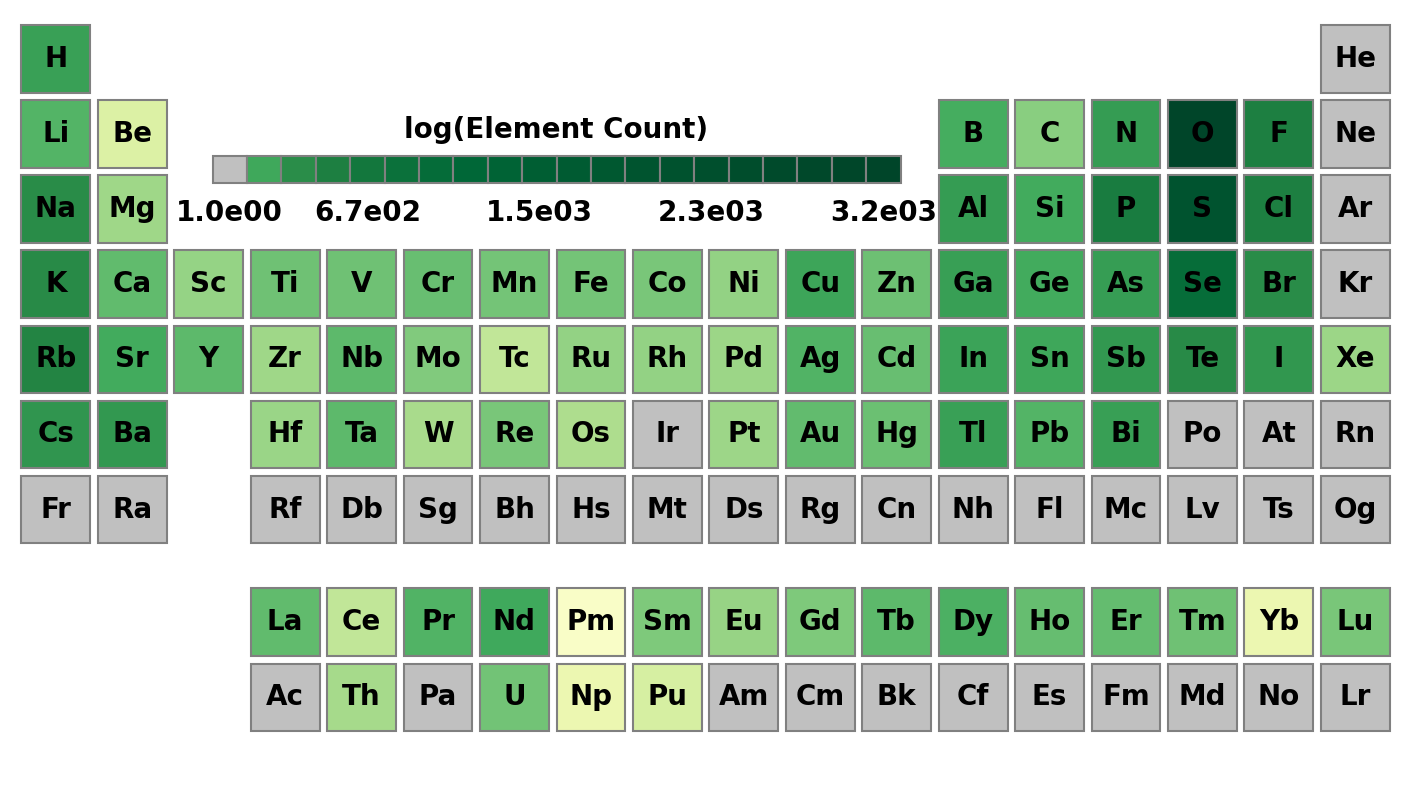

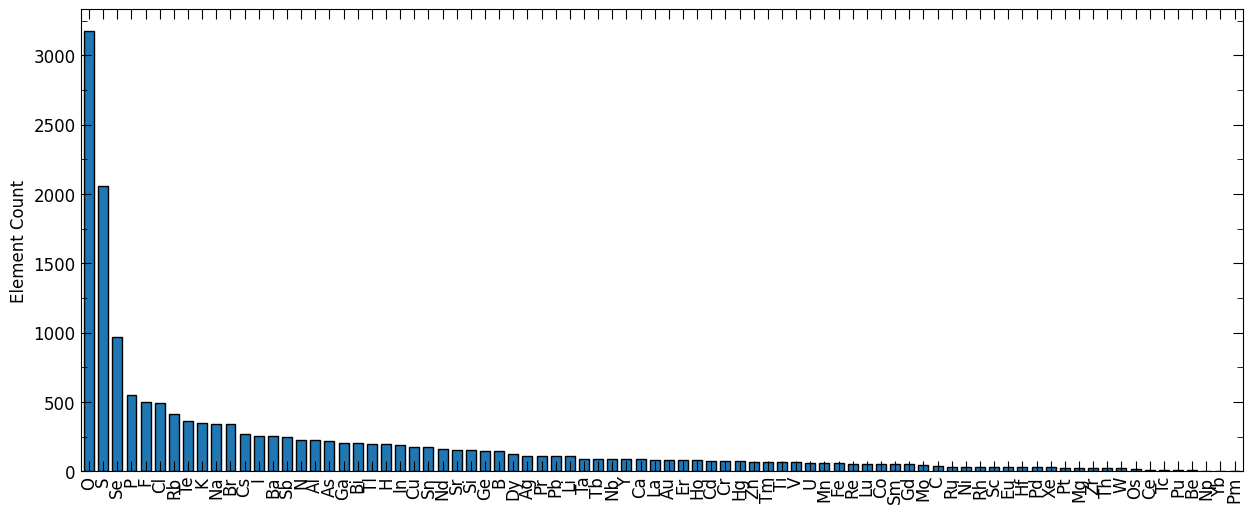

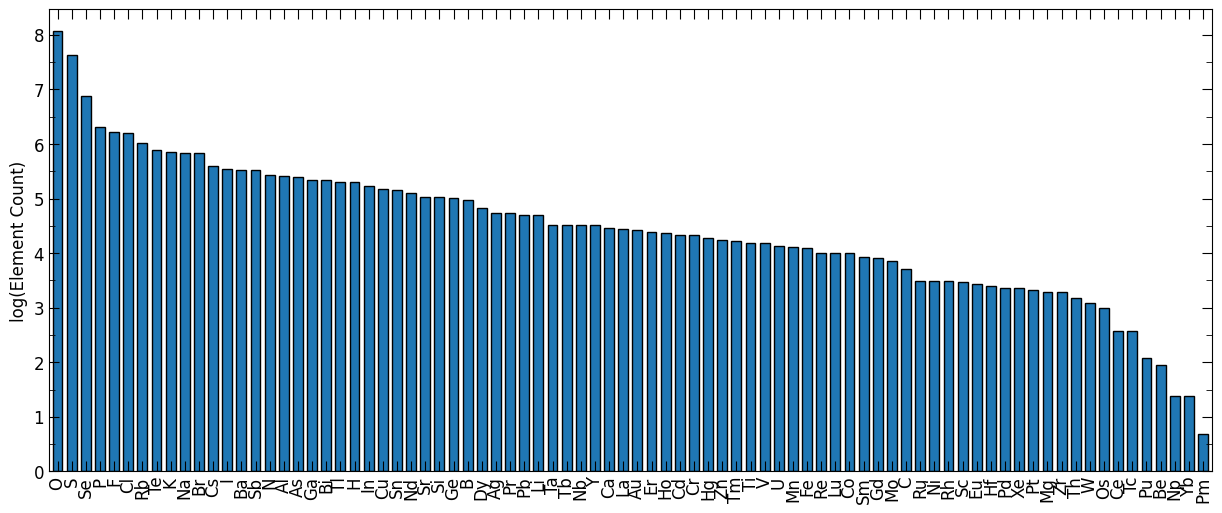

In [16]:
# 误差小于0.1eV的元素分布
from Utools.ML_figures.figures import element_prevalence
import matplotlib.pyplot as plt

data_df = dft_test[dft_test['error'] < 0.1].copy()
current_dir = os.getcwd()
os.chdir('./Utools')  # Change to where ML_figures is a direct subdirectory

formula = data_df['composition']
save_dir = os.path.join(fig_path, 'error_less_than_0.1eV_elements_distribution')
os.makedirs(save_dir, exist_ok=True)
element_prevalence(formula,
                   name='element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=True)

plt.rcParams.update({'font.size': 12})
element_prevalence(formula,
                   name='element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=True)

os.chdir(current_dir)  # Return to previous directory